# Содержание:

<a href='#text_preprocessing'>Обработка текста из книги</a>

 - <a href='#text_preprocessing_1_1'>Получение текста по ссылке</a>
    
 - <a href='#text_preprocessing_1_2'>Очистка текста</a>
    
    
<a href='#top100_word'>Toп100 самых часто используемых нормализованных слов в тексте</a>

 - <a href='#top100_word_2_1'>Поиск топ100 нормализованных слов</a>
    
 - <a href='#top100_word_2_2'>Отображение топ100 слов в виде столбчатой диаграммы</a>
    
 - <a href='#top100_word_2_3'>Отображение топ100 слов в виде "облака" слов</a>


<a href='#words_forms'>Все формы слова для Toп10 самых часто используемых нормализованных слов в тексте</a>

 - <a href='#words_forms_3_1'>Поиск всех форм топ10 слов</a>
    
 - <a href='#words_forms_3_2'>Отображение топ10 слов в виде столбчатых диаграмм</a>


<a href='#nomens'>Имена собственные</a>

In [1]:
import warnings
import pandas as pd
import numpy as np
import re
import string
import pymorphy2
import matplotlib.pyplot as plt
import requests
import math

from collections import Counter
from itertools import groupby
from tqdm.notebook import tqdm
from urllib.request import urlopen
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud
from stop_words import get_stop_words
from PIL import Image
from nltk.corpus import words
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger, 
    Doc, 
)
from typing import (
    List,
    Tuple,
    Dict,
    Counter,
)

warnings.filterwarnings("ignore")

plt.style.use('ggplot')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Обработка текста из книги
<a id='text_preprocessing'></a>

## Получение текста по ссылке
<a id='text_preprocessing_1_1'></a>

In [2]:
def get_text_from_url(url: str) -> Tuple[str, list, str]:
    '''
    Returns tuple of title, paragraphs and text from url
    
    '''
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features='html.parser')
    paragraphs = [''.join(s.findAll(text=True)) for s in soup.findAll('p')]
    title = soup.html.head.title
    text = soup.get_text()
    return title, paragraphs, text

In [3]:
def show_part_of_test(text: str, char_count=2000, is_head=True) -> str:
    '''
    Print part of head or tail of text
    
    '''
    if is_head:
        print(text[:char_count])
    else:
        print(text[-char_count:])

In [4]:
title, paragraphs, text = get_text_from_url(url='http://az.lib.ru/k/kipling_d_r/text_0070.shtml')

In [5]:
title

<title>Lib.ru/Классика: Киплинг Джозеф Редьярд. Книга джунглей</title>

In [6]:
paragraphs

['\nКнига джунглей\n',
 '\nПРЕДИСЛОВИЕ АВТОРА\n',
 '\nБРАТЬЯ МАУГЛИ\n',
 '\nОХОТА ПИТОНА КАА\n',
 '\nТИГР! ТИГР!\n',
 '\nБЕЛЫЙ КОТИК\n',
 '\nРИККИ-ТИККИ-ТАВИ\n',
 '\nМАЛЕНЬКИЙ ТУМАИ\n',
 '\nСЛУГИ ЕЕ ВЕЛИЧЕСТВА\n']

In [7]:
len(text)

270907

In [8]:
show_part_of_test(text)



Lib.ru/Классика: Киплинг Джозеф Редьярд. Книга джунглей



Киплинг Джозеф Редьярд
Книга джунглей


Lib.ru/Классика:



[Регистрация]
 



[Найти] 
[Рейтинги]
[Обсуждения]
[Новинки]
[Обзоры]
[Помощь]









Комментарии: 6, последний от 01/11/2019.
Киплинг Джозеф Редьярд
 (перевод: Чистякова-Вэр Евгения)
 (bmn@lib.ru) 
Год: 1894
Обновлено: 14/09/2017. 280k. Статистика.
Сборник рассказов: Переводы, Сказки, Детская Сказки и легенды


Скачать FB2







Оценка: 4.48*70


 Ваша оценка: 
шедевр
замечательно
очень хорошо
хорошо
нормально
Не читал
терпимо
посредственно
плохо
очень плохо
не читать






Аннотация:Перевод Е. М. Чистяковой-Вэр (1916). 
Предисловие автораБратья МауглиОхота питона КааТигр! Тигр!Белый котикРикки-Тикки-ТавиМаленький ТумаиСлуги ее величества















   Редьярд Киплинг


Книга джунглей


   
   **********************************
   Киплинг Р. Собрание сочинений в 6 т.
   М., ТЕРРА, 1996. Том 3 -- 526 с.
   с. 5-144.
   Перевод Е. М. Чистяковой-Вэр.
   OCR: sa

In [9]:
show_part_of_test(text, is_head=False)

р он не выказывал ни тени изумления или какого-либо другого чувства; теперь же его глаза стали расширяться все больше и больше; он натянул поводья своей лошади и оглянулся. С минуту казалось, что вот-вот он обнажит саблю и прорубит себе дорогу через толпу английских мужчин и женщин, заполнявших экипажи позади него. Движение войск прекратилось; почва успокоилась; вся линия войск салютовала; тридцать оркестров заиграли сразу. Наступил конец парада, и войска под дождем направились к своим лагерям.
        И я услышал, как старый, седой, длинноволосый начальник племени из Центральной Азии, приехавший вместе с эмиром, задавал вопросы одному туземному офицеру:
        -- Скажите, -- спросил он, -- как могли сделать эту удивительную вещь?
        Офицер ответил:
        -- Было дано приказание, его выполнили.
        -- Да разве животные так же умны, как люди? -- продолжал спрашивать азиат.
        -- Они слушаются, как люди. Мул, лошадь, слон или вол, каждый повинуется своему погонщику; пого

## Очистка текста
<a id='text_preprocessing_1_2'></a>

In [10]:
def text_preprocessing(text: str) -> str:
    '''
    Returns clean text without trash symbols
    
    '''
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)
    text_head, sep, text_tail = text.partition('ПРЕДИСЛОВИЕ АВТОРА')
    text, sep, text_tail = text_tail.partition('Комментарии')
    text = re.sub(re.compile(r"<[^>]*>"), " ", text)
    text = re.sub(re.compile(r"^\[id\d*|.*\],*\s*"), "", text)
    text = re.sub(re.compile(r"(&quot;)|(&lt;)|(&gt;)|(&amp;)|(&apos;)"), " ", text)
    text = re.sub(re.compile(r"https?://(www\.)?[-a-zA-Z0-9@:%._+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_+.~#?&/=]*)")," ", text)
    text = re.sub(re.compile(r"\[[^\[\]]+\|([^\[\]]+)\]"), r"\1", text)
    text = re.sub(re.compile(r"(&#\d+;)"), " ", text)
    text = re.sub(re.compile(r"[(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]"), " ", text)
    text = text.replace("  ", " ")
    text = text.replace("--", " ")
    text = text.replace('\n', ' ')
    text = re.sub("\s\s+", " ", text)
    return text

In [11]:
t = text_preprocessing(text)

In [12]:
len(t)

255462

In [13]:
show_part_of_test(t)

 Конечно, сочинение такого рода, как это, требует со стороны редактора обращения к любезности многочисленных специалистов. И плохо отплатил бы он за доброе к себе отношение, если бы не признал себя в долгу перед многими лицами. Прежде всего, он должен поблагодарить высокоученого и талантливого Бахадур Шаха, грузового слона N 174 по списку Индии, который так же, как и его милейшая сестра, Пудмини, в высшей степени любезно сообщили историю Маленького Тумаи и большую часть материала для рассказа Слуги Ея Величества . Сведения для приключения Маугли собирались мало-помалу в различные периоды времени, в различных местах и из уст многих лиц, большая часть которых пожелала сохранить полную анонимность. Тем не менее, находясь в такой дали от них, редактор решается выразить свою признательность одному индусскому высокородному джентльмену, обитателю откосов Джакке, за его убедительную, хотя и несколько сатирическую, характеристику его же собственной касты жрецов служителей храма). Сахи, ученый, 

In [14]:
show_part_of_test(t, is_head=False)

все росла, росла и росла, пока наконец от одного ее конца до другого не образовалось пространство в три четверти мили; это была одна прочная стена из людей, лошадей и орудий. И вот она двинулась прямо на вице-короля и эмира; когда стена эта приблизилась, земля задрожала, как палуба парохода при быстрой работе машин. Если вы не были там, вы не вообразите себе, какое страшное впечатление производит постоянное приближение войск даже на тех зрителей, которые знают, что они видят только парад. Я взглянул на эмира. До этих пор он не выказывал ни тени изумления или какого-либо другого чувства; теперь же его глаза стали расширяться все больше и больше; он натянул поводья своей лошади и оглянулся. С минуту казалось, что вот-вот он обнажит саблю и прорубит себе дорогу через толпу английских мужчин и женщин, заполнявших экипажи позади него. Движение войск прекратилось; почва успокоилась; вся линия войск салютовала; тридцать оркестров заиграли сразу. Наступил конец парада, и войска под дождем напр

# Toп100 самых часто используемых нормализованных слов в тексте
<a id='top100_word'></a>

## Поиск топ100 нормализованных слов
<a id='top100_word_2_1'></a>

In [15]:
def norm_most_freq_words(text: str, freq=100) -> Dict[str, int]:
    '''
    Return most frequent normalizated word in text
    
    '''
    text = re.sub(re.compile(r"[.,!?\;:)(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]"), " ", text)
    stop_words = get_stop_words('russian')
    block_words = ['маугли', 'балу', 'кала', 'наг', 'акела']
    morph = pymorphy2.MorphAnalyzer()
    tokens = [token for token in text.lower().split() if token not in stop_words]
    tokens_ = []
    for word in tqdm(tokens):
        if word in block_words:
            tokens_.append(word)
        else:
            tokens_.append(morph.parse(word)[0].normal_form)
    text = ' '.join(tokens_)
    return dict(Counter(text.split()).most_common(freq))

In [16]:
top100_words = norm_most_freq_words(t)

In [17]:
def ceilm(number: int, multiple: int) -> int:
    return math.ceil(float(number) / multiple) * multiple

In [18]:
def list_to_df(lst: list) -> pd.DataFrame:
    '''
    Convert list of values to pandas datagrame
    
    '''
    d = ceilm(len(lst), 10) - len(lst)
    d_list = [None] * d
    lst = lst + d_list
    return pd.DataFrame(np.array(lst).reshape(int(len(lst) / 10), 10))

In [19]:
list_to_df(list(top100_words.keys()))

,0,1,2,3,4,5,6,7,8,9
0,маугли,котик,маленький,слон,знать,джунгли,голова,мальчик,человек,багира
1,волк,балу,рикки-тикки,свой,тумая,нога,обезьяна,место,один,шер
2,хан,глаз,детёныш,наг,кала,видеть,дерево,земля,говорить,стая
3,большой,мочь,смотреть,каа,мой,морской,слово,сторона,мать,заметить
4,акела,змея,молодой,бояться,ответить,они,убить,лошадь,спросить,тигр
5,брат,отец,больший,старый,друг,такой,вода,твой,дикий,сделать
6,конец,голос,наш,сказать,человеческий,тэдди,нагой,самый,чёрный,ночь
7,дать,вместе,лапа,лежать,делать,шея,услышать,зуб,трава,вперёд
8,дело,наген,думать,стать,народ,спина,мул,должный,хвост,ребёнок
9,посмотреть,закон,который,минута,подняться,остров,берег,идти,животное,сидеть


In [20]:
top100_words

{'маугли': 228,
 'котик': 164,
 'маленький': 140,
 'слон': 133,
 'знать': 121,
 'джунгли': 118,
 'голова': 118,
 'мальчик': 109,
 'человек': 106,
 'багира': 102,
 'волк': 98,
 'балу': 95,
 'рикки-тикки': 94,
 'свой': 93,
 'тумая': 90,
 'нога': 84,
 'обезьяна': 83,
 'место': 82,
 'один': 79,
 'шер': 76,
 'хан': 76,
 'глаз': 75,
 'детёныш': 73,
 'наг': 73,
 'кала': 68,
 'видеть': 67,
 'дерево': 67,
 'земля': 66,
 'говорить': 65,
 'стая': 64,
 'большой': 64,
 'мочь': 63,
 'смотреть': 61,
 'каа': 59,
 'мой': 59,
 'морской': 59,
 'слово': 56,
 'сторона': 55,
 'мать': 54,
 'заметить': 54,
 'акела': 53,
 'змея': 52,
 'молодой': 52,
 'бояться': 51,
 'ответить': 50,
 'они': 50,
 'убить': 50,
 'лошадь': 50,
 'спросить': 49,
 'тигр': 48,
 'брат': 48,
 'отец': 48,
 'больший': 47,
 'старый': 46,
 'друг': 46,
 'такой': 45,
 'вода': 45,
 'твой': 44,
 'дикий': 44,
 'сделать': 43,
 'конец': 43,
 'голос': 43,
 'наш': 42,
 'сказать': 42,
 'человеческий': 42,
 'тэдди': 42,
 'нагой': 42,
 'самый': 41,
 'чё

## Отображение топ100 слов в виде столбчатой диаграммы
<a id='top100_word_2_2'></a>

In [21]:
def plot_bar_most_freq_words(words: dict) -> None:
    '''
    Plot bar with most frequent words
    
    '''
    plt.figure(figsize=(16, 9))
    plt.bar(words.keys(), words.values())
    plt.xticks(rotation=90);

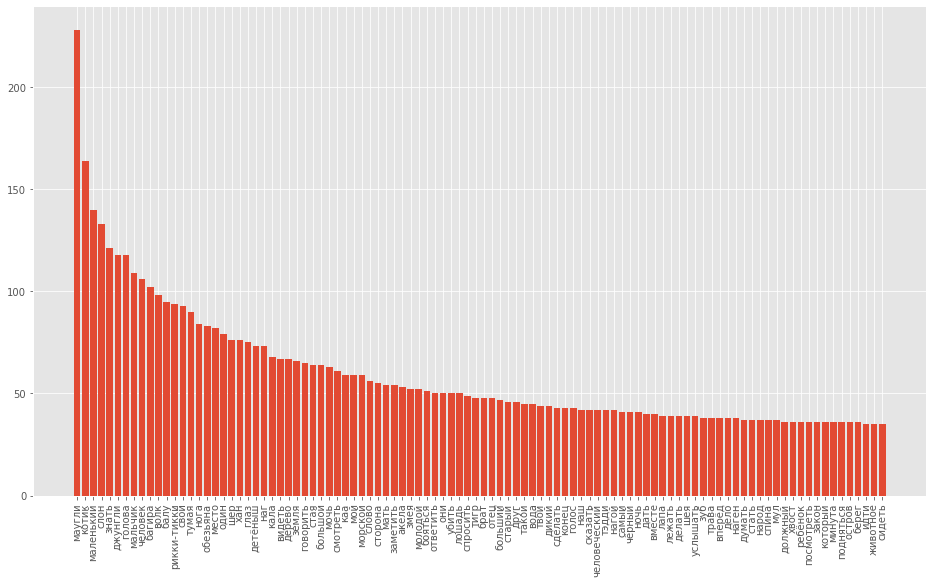

In [22]:
plot_bar_most_freq_words(top100_words)

## Отображение топ100 слов в виде "облака" слов
<a id='top100_word_2_3'></a>

In [23]:
def word_cloud_show(top100_words: dict, pic_name=None) -> None:
    plt.figure(figsize=(15, 10))
    if pic_name is None:
        mask_pic = None
        plt.title('Wordcloud of 100 most frequent words', fontdict={'fontsize': 24})
    else:
        mask_pic = np.array(Image.open(pic_name))
        plt.title('Wordcloud of 100 most frequent words on silhouette of Baloo and Mowgli', fontdict={'fontsize': 24})
    wordcloud = WordCloud(background_color='white',
                          max_words=100,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          mask=mask_pic,
                          contour_width=1,
                          contour_color='steelblue',
                         ).generate_from_frequencies(top100_words)
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis("off");

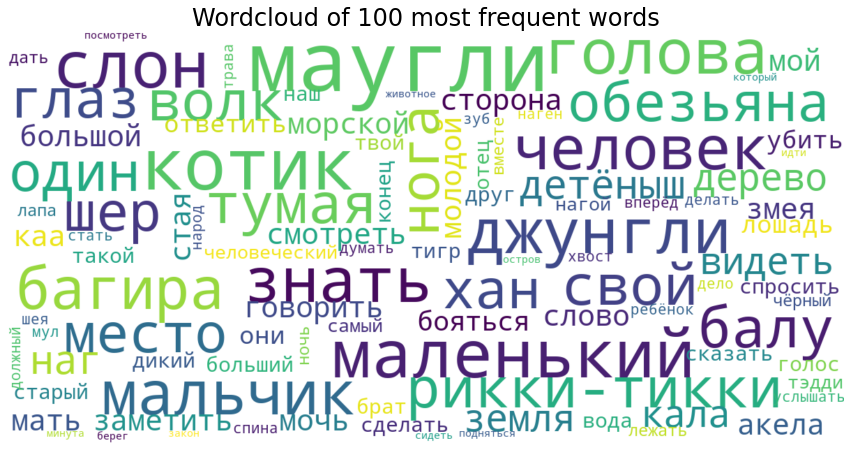

In [24]:
word_cloud_show(top100_words=top100_words)

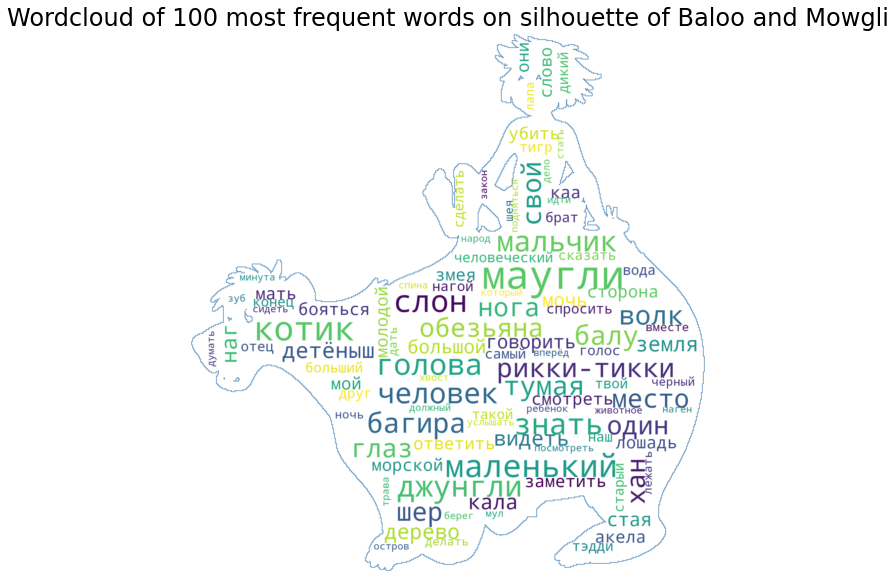

In [25]:
word_cloud_show(top100_words=top100_words, pic_name='mowgli.png')

# Все формы слова для тoп10 самых часто используемых нормализованных слов
<a id='words_forms'></a>

## Поиск всех форм топ10 слов
<a id='words_forms_3_1'></a>

In [26]:
def get_top10_words(top100_words: dict) -> List[int]:
    '''
    Return top10 words from dict
    
    '''
    return list(top100_words.keys())[:10]

top10_words = get_top10_words(top100_words)
top10_words

['маугли',
 'котик',
 'маленький',
 'слон',
 'знать',
 'джунгли',
 'голова',
 'мальчик',
 'человек',
 'багира']

In [27]:
def word_forms_finder(text: str, target_word: str) -> List[str]:
    '''
    Return all forms of word
    
    '''
    text = re.sub(re.compile(r"[.,!?\;:)(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]"), " ", text)
    stop_words = get_stop_words('russian')
    morph = pymorphy2.MorphAnalyzer()
    tokens = [token for token in text.lower().split() if token not in stop_words]
    morph = pymorphy2.MorphAnalyzer()
    form_idx = []
    if target_word == 'маугли':
        for i in range(len(tokens)):
            if tokens[i] == target_word:
                form_idx.append(i)
    else:
        for i in range(len(tokens)):
            if morph.parse(tokens[i])[0].normal_form == target_word:
                form_idx.append(i)
    return np.array(tokens)[form_idx]


def top10_words_forms_finder(top10_words: list) -> List[Counter]:
    '''
    Return all forms of list of words
    
    '''
    return [Counter(word_forms_finder(t, word)) for word in tqdm(top10_words)]

In [28]:
top10_words_forms = top10_words_forms_finder(top10_words)

In [29]:
top10_words_forms

[Counter({'маугли': 228}),
 Counter({'котик': 88,
          'котиков': 29,
          'котика': 21,
          'котики': 12,
          'котиком': 6,
          'котикам': 2,
          'котику': 6}),
 Counter({'маленького': 14,
          'маленькая': 5,
          'маленький': 76,
          'маленьких': 11,
          'маленькое': 7,
          'маленьким': 5,
          'маленьком': 2,
          'маленькой': 4,
          'мал': 1,
          'маленькие': 11,
          'мала': 2,
          'маленькому': 1,
          'маленькими': 1}),
 Counter({'слона': 22,
          'слонах': 1,
          'слон': 17,
          'слоны': 29,
          'слону': 4,
          'слоном': 3,
          'слонов': 51,
          'слонами': 6}),
 Counter({'знать': 9,
          'знал': 40,
          'зная': 2,
          'знаете': 6,
          'знала': 8,
          'знали': 6,
          'знаю': 19,
          'знает': 10,
          'знают': 5,
          'знай': 4,
          'знаешь': 6,
          'знавшая': 1,
          'знае

## Отображение топ10 слов в виде столбчатых диаграмм
<a id='words_forms_3_2'></a>

In [30]:
def top10_words_forms_show(lst: list, top10_words: list) -> None:
    '''
    Plot bars of top10 words
    
    '''
    nrows=5
    ncols=2
    fig, axs = plt.subplots(nrows=nrows,
                            ncols=ncols,
                            figsize=(20, 30),
                            facecolor='w',
                            edgecolor='k',
                           )
    fig.suptitle('Top10 words forms bars', fontsize=24);
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.axis('off')
    axs = axs.ravel()
    for i in range(nrows * ncols):
        lst[i] = dict(sorted(lst[i].items(), key=lambda item: item[1], reverse=True))
        axs[i].set_title(top10_words[i], fontsize=14)
        axs[i].axis('on')
        axs[i].bar(lst[i].keys(), lst[i].values())
        axs[i].set_xticklabels(lst[i].keys(), rotation=45);

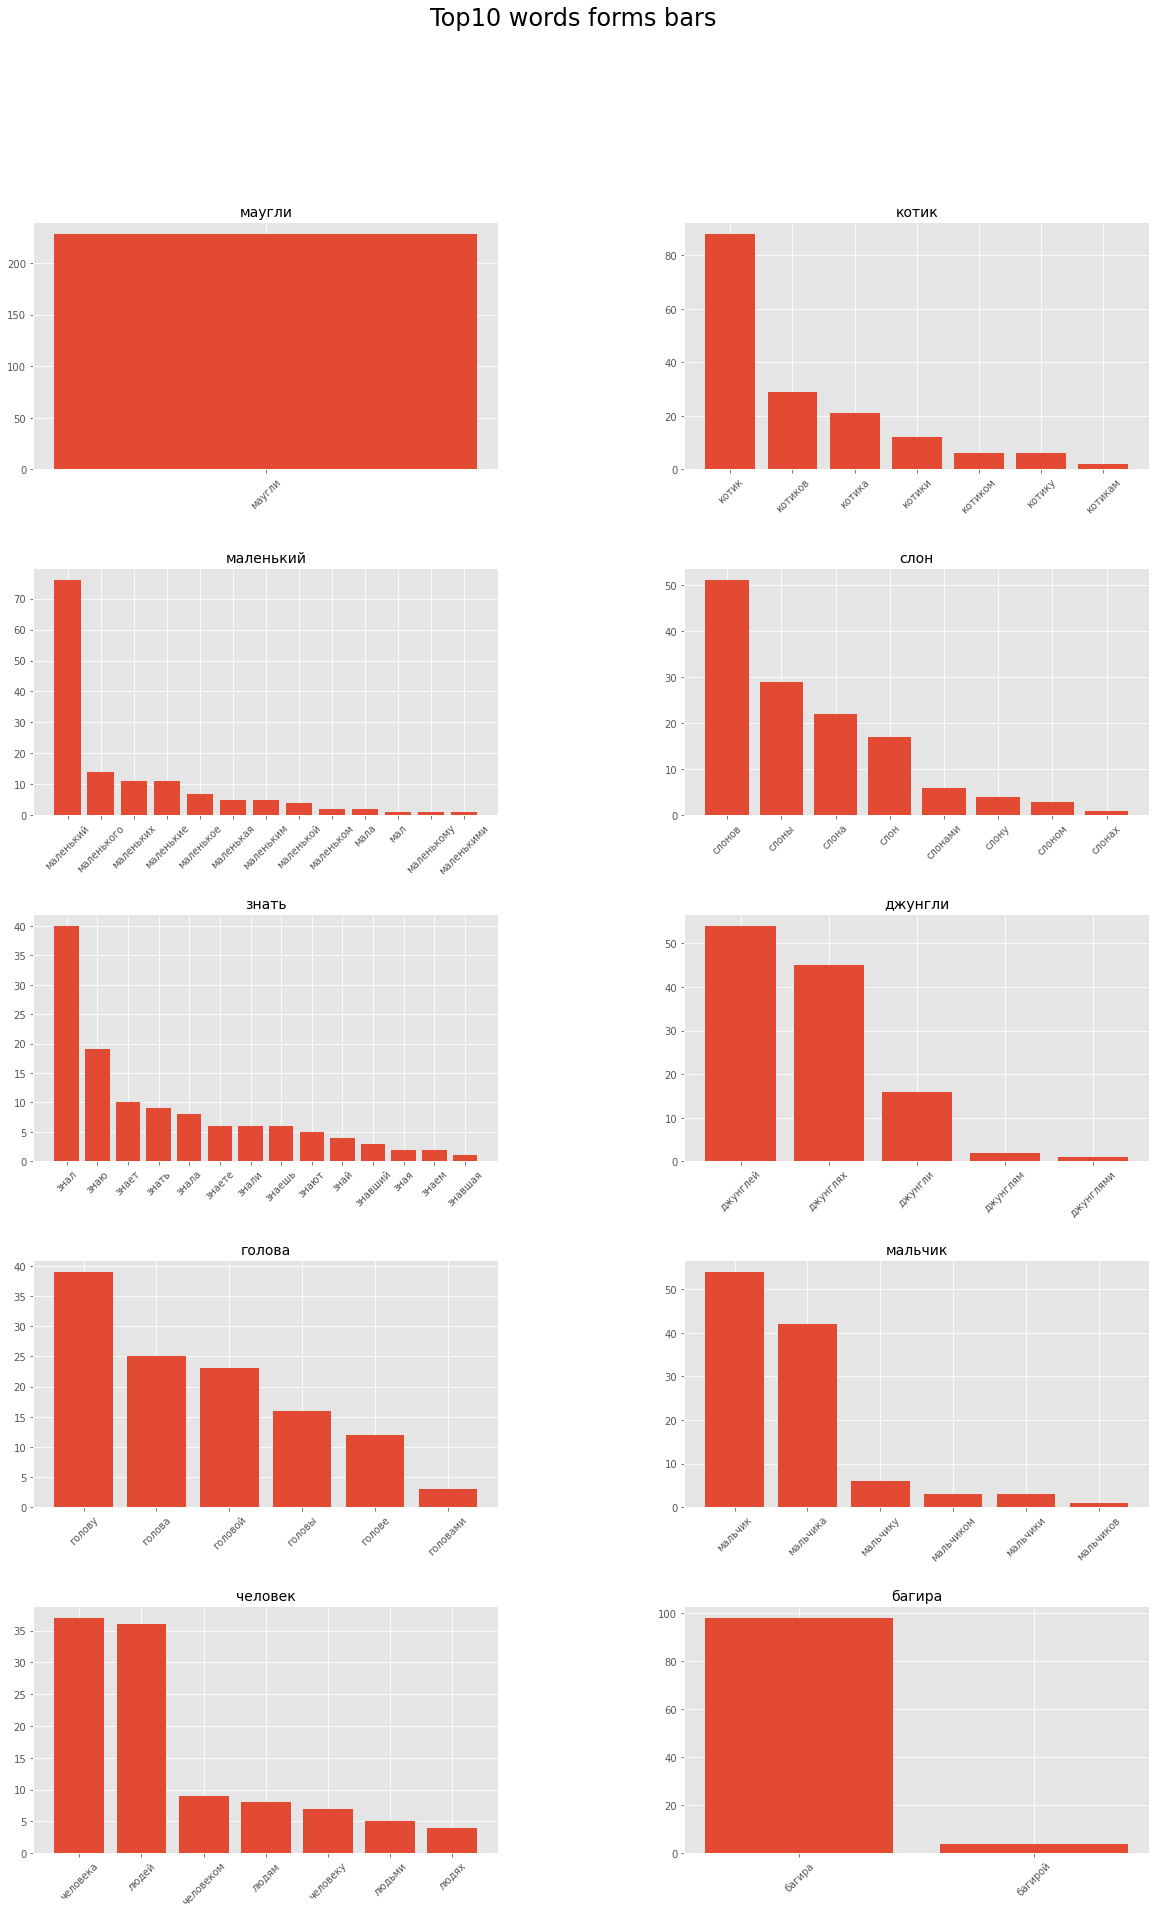

In [31]:
top10_words_forms_show(top10_words_forms, top10_words)

# Имена собственные
<a id='nomens'></a>

In [32]:
def extract(string: str) -> str:
    string.encode('utf8')
    return re.findall(r'\b[А-ЯЁ][а-яё]*\b(?:(?:\s+[А-ЯЁ][а-яЁ]*\b)+|$)', string)

In [33]:
def get_propn(text: str) -> List[str]:
    morph = pymorphy2.MorphAnalyzer()
    segmenter = Segmenter()
    morph_vocab = MorphVocab()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    d = {_.text: _.pos for _ in doc.tokens}
    propns = [item[0] for item in d.items() if item[1] == 'PROPN']
    tag_list = [morph.parse(token)[0].tag.POS for token in propns]
    c = dict(zip(propns, tag_list))
    not_noun_tags = ['VERB', 'INTJ', 'NUMR', 'ADVB', 'PRCL', 'GRND',
                     'COMP','PRTF', 'PRTS', 'PRED', 'PREP', 'INFN', 'CONJ']
    lst = [res[0] for res in list(c.items()) if res[1] not in not_noun_tags]
    block_words = ['маугли', 'балу', 'кала', 'наг', 'акела', 'багира']
    lst = [word for word in lst]
    return list(set([word if word in block_words else morph.parse(word)[0].normal_form for word in lst]))

In [34]:
def text_separator(text: str) -> Tuple[list, list]:
    sents = [sent.strip() for sent in text.split('. ')]
    sent_without_p_mark = [re.sub(re.compile(r"[.,!?\;:)(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]"), " ", sent) for sent in sents]
    first_word = [word.partition(' ')[0] for word in sent_without_p_mark]
    other_words = [sent.partition(' ')[2].strip() for sent in sent_without_p_mark]
    return first_word, other_words

In [35]:
def merger(text: str) -> List[str]:
    parts = text_separator(t)
    part_1 = get_propn(' '.join(text_separator(t)[0]))
    part_2 = [extract(string) for string in text_separator(t)[1]]
    part_2 = list(set([item for sublist in part_2 for item in sublist]))
    return [res.title() for res in list(set(part_1 + part_2)) if len(res) > 2]

In [36]:
list_to_df(merger(t))

,0,1,2,3,4,5,6,7,8,9
0,Холодными Логовищами,Тикки,Учитель,Соленого Дома,Всякий,Да А,Великие Слова Балу,Акелы Смотрите,Наро,Это
1,Сенной Тюк Бились,Большому Тумаи,И Каа,Молчание,Господин,Шер Хан Я,Акелы,Тави,Поступок,Черному Змею
2,Маро Маро Бей,Волк Отец,Зверёк,Маил,Волк,Кобра,Лиммершина,Воздух,Приказ,Магараджа
3,Волк,Багиры,Пудмини,Она,Закона Джунглей Маугли,Раз,Центральной Азии,Бандар-Лог,Эмир,Хуана Фернандеса
4,Сссс,Багира По,Акела Багира,Нату Маугли,Нагой,Рикки,Бал,Пустой,Нагена,Тикки Разве
5,Нату,Тигр,Немногий,Капитан,Таков,Они,Восточному Мысу,Котик,Георгий,Серого Брата
6,Стая,Ээээ-Ссш,Отверженный,Я Мог,Рамы,Совету Смотрите,Лицо,Икки,Свободным Народом,Сын
7,Смерть Над,Красным Цветком,Мангус,Кала Нагу,Охотничий Крик Пришельцев,Двухвостка,Нага Тэдди,Обезьяна,Захарова,Нагену
8,Ву Если,Погонщик,Роса,Полковой,Холмом Гутчинсона,Морской Ловец,Тикки Горлышко Дарси,Великие Слова,Павел,Внимание Маугли
9,Шер Хан,Скалы Совета От,Свободным Народом Вы,Восточный Мыс Луканнон,Право,Петерсный,Волчица Мать,Котик,Осторожнее,Стадо
